For this task, I will use the CIFAR-10 dataset, which consists of 10 classes of coloured images, including airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. The dataset contains 60,000 images - 50,000 images for the training set and 10,000 images for the testing set. Each image is a 32x32 pixel RGB image (3 channels: red, green, and blue), labeled according to its class. The pixel values range from 0 to 255, representing the intensity of each color channel.

Below I will load the dataset and display some of its characteristics mentioned above:

Training set size: 60000 images
Test set size: 10000 images
Image dimensions: 28x28 pixels
Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


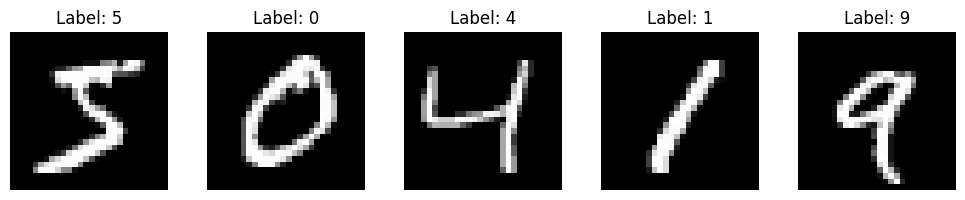

In [55]:
import numpy as np
import matplotlib.pyplot as plt

mnist_data = np.load('./mnist.npz')

x_train, y_train = mnist_data['x_train'], mnist_data['y_train']
x_test, y_test = mnist_data['x_test'], mnist_data['y_test']

print(f"Training set size: {x_train.shape[0]} images")
print(f"Test set size: {x_test.shape[0]} images")
print(f"Image dimensions: {x_train.shape[1]}x{x_train.shape[2]} pixels")
print(f"Labels: {set(y_train)}")

# I will also display some sample images from the dataset to visualise the images I am working with

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

I will create a base convolutional neural network (using PyTorch) to classify these digits.
The MNIST dataset is already almost fully pre-processed and clean, greyscaled and resized to 28x28 pixels.
I will first normalize the pixel values into a range between 0 and 1, to help the neural network converge faster during training:

In [56]:
x_train = x_train / 255.0
x_test = x_test / 255.0

# We can display the max and min value to visualise this

print(f"Max pixel value: {x_train.max()}")
print(f"Min pixel value: {x_test.min()}")

Max pixel value: 1.0
Min pixel value: 0.0


Next I need to convert both the training and testing set to PyTorch tensors as this is what the model expects. 
Since the neural network is convolutional, I will need to retain the 2D structure (height x width) and add an extra channel dimension for greyscale too, indicating the depth of the image:

In [57]:
import torch

x_train = torch.tensor(x_train, dtype=torch.float32) 
x_test = torch.tensor(x_test, dtype=torch.float32)

x_train = x_train.unsqueeze(1) # becomes (60000, 1, 28, 28)
x_test = x_test.unsqueeze(1)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)


The labels are currently ranging from 0-9, so I will need to one-hot encode them into a binary vector for each, specifying the amount of classes:

In [58]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

print(f"Example one-hot encoded label: {y_train_one_hot[0]}")

Example one-hot encoded label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Now the input is prepared, I will start building the model.
I will first need to establish a baseline CNN model, which I will build on and add improvements, and then carry out hyperparameter tuning:

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 1 Convolutional Layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        
        # 1 Fully Connected Layer
        self.fc1 = nn.Linear(8 * 26 * 26, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)  
        return x
    
model = CNN()

# Baseline Hyperparameters

batch_size = 64
learning_rate = 0.01
num_epochs = 3

To start with, I have defined a simple base convolutional network with 1 convolutional layer and 1 fully connected layer, and no hidden layers. 

In the forward pass function, the first convolutional layer is applied with a ReLU activation function. Then the feature maps are flattened into 1D to be fed into the fully connected layer. Then the first fully connected layer is applied with no activation as it is handled in the loss function.

Under this, I have specified the hyperparameters that I will start off with:
- Batch size: 64 - (higher = more stable gradient updates but slower weight updates, lower = faster weight updates but gradients are noiser)
- Learning rate: 0.01 - (higher = faster training but risk of overshooting the minimum, lower = slower training but ensures more stable and precise convergence at minimum)
- Epochs: 3 - (higher = risk of overfitting, lower = risk of underfitting)

I also need to define the loss function and the optimizer for the baseline model. I will use cross-entropy loss as it is standard for multi-class classification problems, and also the adam optimizer:

In [60]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Before training I will also need to wrap the data in loaders now that batch size is defined:

In [61]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Now I will train the model for the specified baseline number of epochs:

In [62]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")   

Epoch [1/3], Loss: 0.2922, Accuracy: 92.57%
Epoch [2/3], Loss: 0.0976, Accuracy: 97.20%
Epoch [3/3], Loss: 0.0723, Accuracy: 97.71%
